# Task 1: Preprocessing
- **merging**: the images in the original dataset are devided into `train`, `validation` and `test` subdirectories; images were all merged into a single directory in order to restructure database;
- **check for duplicate images**: using Python cv2 module we identified images with the same exact content but different names; such images were deleted;
- **manual clean up**: after manual inspection of the dataset, it turned out that many of the images found in the directories were not related to the class label but accidentally ended up in the dataset as a result of the web scraping procedure used to collect images from Bing Images; such images were deleted;
- **check images formats**: we noticed the presence of different extensions for the images in the dataset: png, jpg, jpeg, PNG, JPG, JPEG; `tf.keras` should handle different formats without much of a hassle;
- **balancing data**: it has been used as oversampling method in order to balance binary dataset,
- **binarization**: images were split into the two parent families fruits and vegetables;

Before running this notebook:
- remove whitespaces from directories names;
- rename `jalepeño` to `jalapeno`;

--

- decode the image content to RGB grids of pixels;
- normalize pixel values to be compatible with the chosen model;
- convert these into floating point tensors;
- resize them to a shared size;
- pack them into batches.

In [ ]:
# necessary imports
import os
import cv2
import uuid
import time
import shutil
import random
import calendar
import numpy as np
from matplotlib import *
from shutil import copyfile
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.image as mpimg

In [ ]:
# authenticate and mount GDrive
drive.mount('/content/drive')

# define known paths in GDrive
PATH_HOME = '/content/drive/Shareddrives/CIDL'
PATH_DATASET = PATH_HOME + '/dataset'
PATH_ORIGINAL_DATASET = PATH_DATASET + '/original'
PATH_ORIGINAL_BINARY_DATASET = PATH_DATASET + '/original_binary'
PATH_PREPROCESSED_DATASET = PATH_DATASET + '/preprocessed'
PATH_PREPROCESSED_BINARY_DATASET = PATH_DATASET + '/preprocessed_binary'
PATH_AUGMENTED_DATASET = PATH_DATASET + '/augmented'
PATH_AUGMENTED_BINARY_DATASET = PATH_DATASET + '/augmented_binary'

Mounted at /content/drive


## Merging
The original dataset directory is devided into the `train`, `test` and `validation` subdirectories. 

In [ ]:
# create preprocessed dataset directory if it does not exist
if not (os.path.exists(PATH_PREPROCESSED_DATASET)):
  os.mkdir(PATH_PREPROCESSED_DATASET)

# create classes subdirectories for the preprocessed dataset
splits = os.listdir(PATH_ORIGINAL_DATASET)
for split in splits:
  class_labels = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split))
  for label in class_labels:
    if not (os.path.exists(os.path.join(PATH_PREPROCESSED_DATASET, label))):
      os.mkdir(os.path.join(PATH_PREPROCESSED_DATASET, label))

# incremental images counter
counter = 0

# retrieve and move images
splits = os.listdir(PATH_ORIGINAL_DATASET)
for split in splits:
  class_labels = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split))
  for label in class_labels:
    files = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split, label))
    for image_file in files:
      filename, file_extension = os.path.splitext(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file))
      new_filename = 'img_' + str(counter) + file_extension
      shutil.copyfile(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file), os.path.join(PATH_PREPROCESSED_DATASET, label, new_filename))
      counter = counter + 1

## Check for duplicate images
Using Python cv2 module we identified images with the same exact content but different file names; such images were deleted.

In [ ]:
# use this to keep progress of the duplicates preprocessing
processed_labels = ['corn', 'lemon', 'cabbage', 'garlic', 'spinach', 'capsicum', 'tomato', 'mango', 'turnip', 'cauliflower', 'kiwi', 'watermelon', 'orange', 'lettuce', 'onion', 'banana', 'beetroot', 'apple', 'pomegranate', 'potato', 'cucumber', 'pear', 'peas', 'carrot', 'pineapple', 'grapes', 'ginger', 'jalapeno', 'eggplant', 'sweetpotato', 'raddish', 'paprika', 'chilli_pepper', 'soy_beans']

In [ ]:
%matplotlib inline

# utility function used to check if two images are equal
def compare_images(path1, path2):
  try:
    image1 = cv2.imread(path1)
    image2 = cv2.imread(path2)

    # first check if the two images have the same shape
    if image1 is not None and image2 is not None:
      if image1.shape != image2.shape:
        return [255, 255, 255]

    # compute difference
    diff = cv2.subtract(image1, image2)
    return cv2.split(diff)
  except Exception:
        pass

# figure size in inches optional
rcParams['figure.figsize'] = 6,3

# loop through images and check for duplicate images
class_labels = os.listdir(PATH_PREPROCESSED_DATASET)
for current_label in class_labels:
  print("Current class: " + current_label)
  if not current_label in processed_labels:
    files = os.listdir(os.path.join(PATH_PREPROCESSED_DATASET, current_label))
    for current_image_file in files:
      for label in class_labels:
        if label == current_label:
          for image_file in files:
            if (image_file != current_image_file and os.path.isfile(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file)) and os.path.isfile(os.path.join(PATH_PREPROCESSED_DATASET, label, current_image_file))):
              comparison = compare_images(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file), os.path.join(PATH_PREPROCESSED_DATASET, label, current_image_file))
              if comparison is not None:
                if (len(comparison) > 0):
                  b, g, r = comparison
                  if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
                    image1 = mpimg.imread(os.path.join(PATH_PREPROCESSED_DATASET, label, current_image_file))
                    image2 = mpimg.imread(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file))
                    fig, ax = plt.subplots(1, 2)
                    ax[0].imshow(image1)
                    ax[1].imshow(image2)
                    plt.show()
                    print(os.path.join(PATH_PREPROCESSED_DATASET, label, current_image_file))
                    print(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file))

                    print("Deleting " + os.path.join(PATH_PREPROCESSED_DATASET, label, image_file))
                    to_be_deleted = os.path.join(PATH_PREPROCESSED_DATASET, label, image_file)
                    %rm $to_be_deleted

### Manual Cleanup
After manual inspection of the dataset, it turned out that many of the images found in the directories were not related to the class label but accidentally ended up in the dataset as a result of the web scraping procedure used to collect images from Bing Images; after many attempts of writing a functioning interactive script to visualize and delete such images, the choice was made to perform this task manually since the Jupiter notebook does not provide the level of interaction required in order to progressively visualize all images in the dataset and decide which ones to keep and which ones to delete.

The manual cleanup was conducted with the following criterias in mind:
- the `corn` and `sweet corn` classes were merged because extremely similar;
- the `capsicum` and `bell pepper` classes were merged because extremely similar;
- the `paprika` class was deleted;
- images containing dishes and meals based on the class label fruit or vegetable were deleted;
- images containing fields of the given fuir or vegetable were deleted;
- images completely unrelated with the class label were deleted;

In [ ]:
from google.colab.patches import cv2_imshow

rcParams['figure.figsize'] = 6,3

# loop through all images
labels = os.listdir(PATH_PREPROCESSED_DATASET)
for label in labels:
  files = os.listdir(os.path.join(PATH_PREPROCESSED_DATASET, label))
  for image_file in files:
    image = mpimg.imread(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file))
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image)
    fig.show()
    plt.show(block=True)

    # ask deletion confirmation
    delete = input("Would you like to delete this image? [Y/n]")
    if (delete == 'Y'):
      print("THIS MUST BE DELETED.")

## Check images formats
We noticed the presence of different extensions for the images in the dataset: png, jpg, jpeg, PNG, JPG, JPEG; `tf.keras` should handle different formats without much of a hassle;

In [ ]:
extensions = {}

for root, dirs, files in os.walk(PATH_PREPROCESSED_DATASET, topdown=False):
  for name in files:
    image = os.path.join(root, name)
    ext = image.split(".")[-1]
    if ext in extensions:
      extensions[ext] = extensions[ext] + 1
    else:
      extensions[ext] = 1

print(extensions)

{'jpg': 2325, 'png': 212, 'JPG': 66, 'jpeg': 48}


## Code used for balancing dataset


In [ ]:
# use this to keep progress of the data preprocessing
processed_labels = ['corn', 'lemon', 'cabbage', 'garlic', 'spinach', 'capsicum', 'tomato', 'mango', 'turnip', 'cauliflower', 'kiwi', 'watermelon', 'orange', 'lettuce', 'onion', 'banana', 'beetroot', 'apple', 'pomegranate', 'potato', 'cucumber', 'pear', 'peas', 'carrot', 'pineapple', 'grapes', 'ginger', 'eggplant', 'sweetpotato', 'raddish']

In [ ]:
# utility function to rotate the given image by the given angle
def rotate(image, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    image = cv2.warpAffine(image, M, (w, h))
    return image

# create augmented dataset directory if it does not exist
if not (os.path.exists(PATH_AUGMENTED_DATASET)):
  os.mkdir(PATH_AUGMENTED_DATASET)

# create classes subdirectories for the augmented dataset
labels = os.listdir(PATH_PREPROCESSED_DATASET)
for label in labels:
  if not (os.path.exists(os.path.join(PATH_AUGMENTED_DATASET, label))):
    os.mkdir(os.path.join(PATH_AUGMENTED_DATASET, label))

# rotation angle
rotation_angle = 45

# loop through images and check for duplicate images
labels = os.listdir(PATH_PREPROCESSED_DATASET)
for label in labels:
  print("Current class: " + label)
  if not label in processed_labels:
    files = os.listdir(os.path.join(PATH_PREPROCESSED_DATASET, label))
    for image_file in files:
      image = cv2.imread(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file))
      if image is not None:
        cv2.imwrite(os.path.join(PATH_AUGMENTED_DATASET, label, image_file), image)
        filename, file_extension = os.path.splitext(image_file)
        for i in range(7):
          rotated_image = rotate(image, rotation_angle)
          cv2.imwrite(os.path.join(PATH_AUGMENTED_DATASET, label, filename + '-rotated-' + str(i) + file_extension), rotated_image)
          rotation_angle = rotation_angle + 45

Current class: corn
Current class: lemon
Current class: cabbage
Current class: garlic
Current class: spinach
Current class: tomato
Current class: mango
Current class: turnip
Current class: cauliflower
Current class: kiwi
Current class: watermelon
Current class: orange
Current class: lettuce
Current class: onion
Current class: banana
Current class: beetroot
Current class: apple
Current class: pomegranate
Current class: potato
Current class: cucumber
Current class: pear
Current class: peas
Current class: carrot
Current class: pineapple
Current class: grapes
Current class: ginger
Current class: eggplant
Current class: sweetpotato
Current class: raddish
Current class: bell_pepper
Current class: chilli_pepper
Current class: soy_beans
Current class: jalapeno


### Horizontal flip

In [ ]:
%matplotlib inline

rcParams['figure.figsize'] = 11,8

image = cv2.imread('/content/drive/Shareddrives/CIDL/dataset/preprocessed/corn/img_3946.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flipped_image = cv2.flip(image, 1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(flipped_image)
plt.show()

error: ignored

### Vertical flip

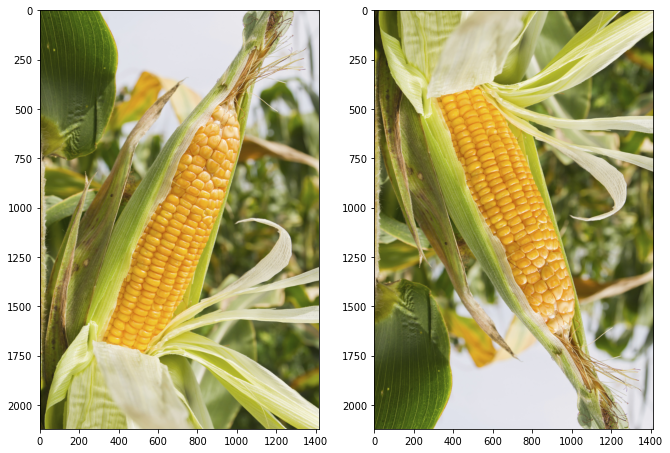

In [ ]:
%matplotlib inline

rcParams['figure.figsize'] = 11,8

image = cv2.imread('/content/drive/Shareddrives/CIDL/dataset/preprocessed/corn/img_3946.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
flipped_image = cv2.flip(image, 0)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(flipped_image)
plt.show()

### Rotation

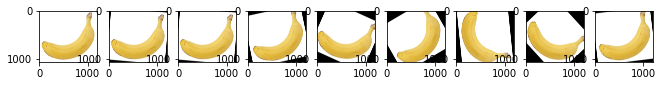

In [ ]:
%matplotlib inline

def rotate(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

rcParams['figure.figsize'] = 11,8

image = cv2.imread('/content/drive/Shareddrives/CIDL/dataset/preprocessed/banana/img_183.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rotated_image_1 = rotate(image, 10)
rotated_image_2 = rotate(image, 20)
rotated_image_3 = rotate(image, 40)
rotated_image_4 = rotate(image, 60)
rotated_image_5 = rotate(image, 90)
rotated_image_6 = rotate(image, 120)
rotated_image_7 = rotate(image, 150)
rotated_image_8 = rotate(image, 180)

fig, ax = plt.subplots(1, 9)
ax[0].imshow(image)
ax[1].imshow(rotated_image_1)
ax[2].imshow(rotated_image_2)
ax[3].imshow(rotated_image_3)
ax[4].imshow(rotated_image_4)
ax[5].imshow(rotated_image_5)
ax[6].imshow(rotated_image_6)
ax[7].imshow(rotated_image_7)
ax[8].imshow(rotated_image_8)
plt.show()

### Combination


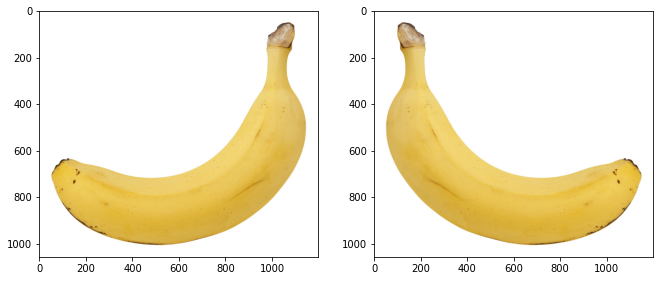

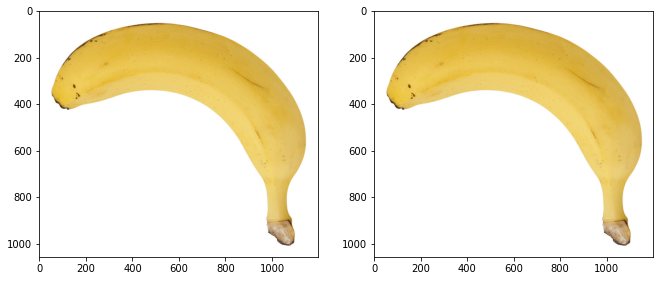

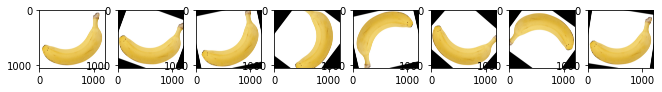

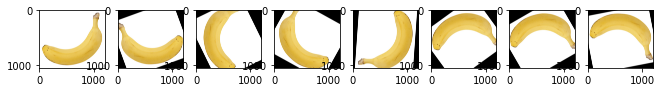

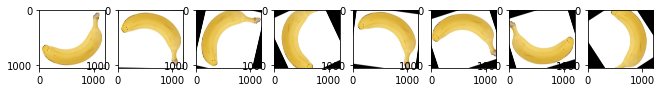

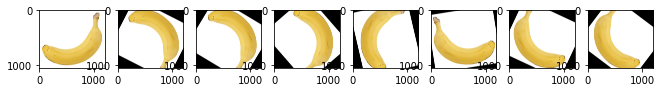

In [ ]:
%matplotlib inline

rcParams['figure.figsize'] = 11,8

image = cv2.imread('/content/drive/Shareddrives/CIDL/dataset/preprocessed/banana/img_183.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hf_image = cv2.flip(image, 1)
vf_image = cv2.flip(image, 0)
vf_hf_image = cv2.flip(image, 0)

# original image and horizontal flip
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image)
ax[1].imshow(hf_image)
plt.show()

# vertical flips of the original and of the horizontal flip
fig, ax = plt.subplots(1, 2)
ax[0].imshow(vf_image)
ax[1].imshow(vf_hf_image)
plt.show()

# rotate original
rotated_image_1 = rotate(image, 45)
rotated_image_2 = rotate(image, 90)
rotated_image_3 = rotate(image, 135)
rotated_image_4 = rotate(image, 180)
rotated_image_5 = rotate(image, 225)
rotated_image_6 = rotate(image, 270)
rotated_image_7 = rotate(image, 315)

fig, ax = plt.subplots(1, 8)
ax[0].imshow(image)
ax[1].imshow(rotated_image_1)
ax[2].imshow(rotated_image_2)
ax[3].imshow(rotated_image_3)
ax[4].imshow(rotated_image_4)
ax[5].imshow(rotated_image_5)
ax[6].imshow(rotated_image_6)
ax[7].imshow(rotated_image_7)
plt.show()

# rotate horizontal flip
rotated_hf_image_1 = rotate(hf_image, 45)
rotated_hf_image_2 = rotate(hf_image, 90)
rotated_hf_image_3 = rotate(hf_image, 135)
rotated_hf_image_4 = rotate(hf_image, 180)
rotated_hf_image_5 = rotate(hf_image, 225)
rotated_hf_image_6 = rotate(hf_image, 270)
rotated_hf_image_7 = rotate(hf_image, 315)

fig, ax = plt.subplots(1, 8)
ax[0].imshow(hf_image)
ax[1].imshow(rotated_hf_image_1)
ax[2].imshow(rotated_hf_image_2)
ax[3].imshow(rotated_hf_image_3)
ax[4].imshow(rotated_hf_image_4)
ax[5].imshow(rotated_hf_image_5)
ax[6].imshow(rotated_hf_image_6)
ax[7].imshow(rotated_hf_image_7)
plt.show()

# rotate vertical flip of the original
rotated_vf_image_1 = rotate(vf_image, 45)
rotated_vf_image_2 = rotate(vf_image, 90)
rotated_vf_image_3 = rotate(vf_image, 135)
rotated_vf_image_4 = rotate(vf_image, 180)
rotated_vf_image_5 = rotate(vf_image, 225)
rotated_vf_image_6 = rotate(vf_image, 270)
rotated_vf_image_7 = rotate(vf_image, 315)

fig, ax = plt.subplots(1, 8)
ax[0].imshow(vf_image)
ax[1].imshow(rotated_vf_image_1)
ax[2].imshow(rotated_vf_image_2)
ax[3].imshow(rotated_vf_image_3)
ax[4].imshow(rotated_vf_image_4)
ax[5].imshow(rotated_vf_image_5)
ax[6].imshow(rotated_vf_image_6)
ax[7].imshow(rotated_vf_image_7)
plt.show()

# rotate vertical of the horizontal flip
rotated_vf_hf_image_1 = rotate(vf_hf_image, 45)
rotated_vf_hf_image_2 = rotate(vf_hf_image, 90)
rotated_vf_hf_image_3 = rotate(vf_hf_image, 135)
rotated_vf_hf_image_4 = rotate(vf_hf_image, 180)
rotated_vf_hf_image_5 = rotate(vf_hf_image, 225)
rotated_vf_hf_image_6 = rotate(vf_hf_image, 270)
rotated_vf_hf_image_7 = rotate(vf_hf_image, 315)

fig, ax = plt.subplots(1, 8)
ax[0].imshow(vf_hf_image)
ax[1].imshow(rotated_vf_hf_image_1)
ax[2].imshow(rotated_vf_hf_image_2)
ax[3].imshow(rotated_vf_hf_image_3)
ax[4].imshow(rotated_vf_hf_image_4)
ax[5].imshow(rotated_vf_hf_image_5)
ax[6].imshow(rotated_vf_hf_image_6)
ax[7].imshow(rotated_vf_hf_image_7)
plt.show()

### Binarization
The images of the dataset were split into the two parent families fruits and vegetables. This process was applied to the *original* dataset and the *preprocessed* dataset.

In [ ]:
# fruits classes
fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango', 'lemon']

# vegetables classes
vegetables = ['cucumber', 'carrot', 'capsicum', 'onion', 'potato', 'lemon', 'tomato', 'raddish', 'beetroot', 'cabbage', 'lettuce', 'spinach', 'soy_beans', 'cauliflower', 'bell_pepper', 'chilli_pepper', 'turnip', 'corn', 'sweetcorn', 'sweetpotato', 'paprika', 'jalapeno', 'ginger', 'garlic', 'peas', 'eggplant']

# create original dataset binary directory if it does not exist
print("Original Dataset")
print("----------------")
if not (os.path.exists(PATH_ORIGINAL_BINARY_DATASET)):
  os.mkdir(PATH_ORIGINAL_BINARY_DATASET)
  os.mkdir(os.path.join(PATH_ORIGINAL_BINARY_DATASET, "fruits"))
  os.mkdir(os.path.join(PATH_ORIGINAL_BINARY_DATASET, "vegetables"))

# populate binary original dataset directory starting from the original dataset
splits = os.listdir(PATH_ORIGINAL_DATASET)
for split in splits:
  class_labels = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split))
  for label in class_labels:
    print("Current class: " + label)
    files = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split, label))
    if label in fruits:
      for image_file in files:
        copyfile(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file), os.path.join(PATH_ORIGINAL_BINARY_DATASET, 'fruits', image_file))
    elif label in vegetables:
      for image_file in files:
        copyfile(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file), os.path.join(PATH_ORIGINAL_BINARY_DATASET, 'vegetables', image_file))
    else:
      print("CLASS NOT FOUND.")

# create preprocessed dataset binary directory if it does not exist
print("\nPreprocessed Dataset")
print("----------------")
if not (os.path.exists(PATH_PREPROCESSED_BINARY_DATASET)):
  os.mkdir(PATH_PREPROCESSED_BINARY_DATASET)
  os.mkdir(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, "fruits"))
  os.mkdir(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, "vegetables"))

# populate binary preprocessed dataset directory starting from the preprocessed dataset
labels = os.listdir(PATH_PREPROCESSED_DATASET)
for label in labels:
  print("Current class: " + label)
  files = os.listdir(os.path.join(PATH_PREPROCESSED_DATASET, label))
  if label in fruits:
    for image_file in files:
      copyfile(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file), os.path.join(PATH_PREPROCESSED_BINARY_DATASET, 'fruits', image_file))
  elif label in vegetables:
    for image_file in files:
      copyfile(os.path.join(PATH_PREPROCESSED_DATASET, label, image_file), os.path.join(PATH_PREPROCESSED_BINARY_DATASET, 'vegetables', image_file))
  else:
    print("CLASS NOT FOUND.")

# create augmented dataset binary directory if it does not exist
print("\nAugmented Dataset")
print("----------------")
if not (os.path.exists(PATH_AUGMENTED_BINARY_DATASET)):
  os.mkdir(PATH_AUGMENTED_BINARY_DATASET)
  os.mkdir(os.path.join(PATH_AUGMENTED_BINARY_DATASET, "fruits"))
  os.mkdir(os.path.join(PATH_AUGMENTED_BINARY_DATASET, "vegetables"))

# populate binary augmented dataset directory starting from the augmented dataset
labels = os.listdir(PATH_AUGMENTED_DATASET)
for label in labels:
  print("Current class: " + label)
  files = os.listdir(os.path.join(PATH_AUGMENTED_DATASET, label))
  if label in fruits:
    for image_file in files:
      copyfile(os.path.join(PATH_AUGMENTED_DATASET, label, image_file), os.path.join(PATH_AUGMENTED_BINARY_DATASET, 'fruits', image_file))
  elif label in vegetables:
    for image_file in files:
      copyfile(os.path.join(PATH_AUGMENTED_DATASET, label, image_file), os.path.join(PATH_AUGMENTED_BINARY_DATASET, 'vegetables', image_file))
  else:
    print("CLASS NOT FOUND.")

Original Dataset
----------------
Current class: corn
Current class: lemon
Current class: cabbage
Current class: garlic
Current class: spinach
Current class: sweetcorn
Current class: capsicum
Current class: tomato
Current class: mango
Current class: turnip
Current class: cauliflower
Current class: kiwi
Current class: watermelon
Current class: orange
Current class: lettuce
Current class: onion
Current class: banana
Current class: beetroot
Current class: apple
Current class: pomegranate
Current class: potato
Current class: cucumber
Current class: pear
Current class: peas
Current class: carrot
Current class: pineapple
Current class: grapes
Current class: ginger
Current class: eggplant
Current class: sweetpotato
Current class: raddish
Current class: paprika
Current class: jalapeno
Current class: bell_pepper
Current class: chilli_pepper
Current class: soy_beans
Current class: lemon
Current class: cabbage
Current class: spinach
Current class: tomato
Current class: corn
Current class: garlic


In [ ]:
# fruits classes
fruits = ['banana', 'apple', 'pear', 'grapes', 'orange', 'kiwi', 'watermelon', 'pomegranate', 'pineapple', 'mango', 'lemon']

# vegetables classes
vegetables = ['cucumber', 'carrot', 'capsicum', 'onion', 'potato', 'lemon', 'tomato', 'raddish', 'beetroot', 'cabbage', 'lettuce', 'spinach', 'soy_beans', 'cauliflower', 'bell_pepper', 'chilli_pepper', 'turnip', 'corn', 'sweetcorn', 'sweetpotato', 'paprika', 'jalapeno', 'ginger', 'garlic', 'peas', 'eggplant']

# incremental images counter
counter = 0

# create original dataset binary directory if it does not exist
print("Original Dataset")
print("----------------")
if not (os.path.exists(PATH_ORIGINAL_BINARY_DATASET)):
  os.mkdir(PATH_ORIGINAL_BINARY_DATASET)
  os.mkdir(os.path.join(PATH_ORIGINAL_BINARY_DATASET, "fruits"))
  os.mkdir(os.path.join(PATH_ORIGINAL_BINARY_DATASET, "vegetables"))

# populate binary original dataset directory starting from the original dataset
splits = os.listdir(PATH_ORIGINAL_DATASET)
for split in splits:
  class_labels = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split))
  for label in class_labels:
    print("Current class: " + label)
    files = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split, label))
    if label in fruits:
      for image_file in files:
        filename, file_extension = os.path.splitext(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file))
        new_filename = 'img_' + str(counter) + file_extension
        shutil.copyfile(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file), os.path.join(PATH_ORIGINAL_BINARY_DATASET, 'fruits', new_filename))
        counter = counter + 1
    elif label in vegetables:
      for image_file in files:
        filename, file_extension = os.path.splitext(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file))
        new_filename = 'img_' + str(counter) + file_extension
        shutil.copyfile(os.path.join(PATH_ORIGINAL_DATASET, split, label, image_file), os.path.join(PATH_ORIGINAL_BINARY_DATASET, 'vegetables', new_filename))
        counter = counter + 1
    else:
      print("CLASS NOT FOUND.")

Original Dataset
----------------
Current class: corn
Current class: lemon
Current class: cabbage
Current class: garlic
Current class: spinach
Current class: sweetcorn
Current class: capsicum
Current class: tomato
Current class: mango
Current class: turnip
Current class: cauliflower
Current class: kiwi
Current class: watermelon
Current class: orange
Current class: lettuce
Current class: onion
Current class: banana
Current class: beetroot
Current class: apple
Current class: pomegranate
Current class: potato
Current class: cucumber
Current class: pear
Current class: peas
Current class: carrot
Current class: pineapple
Current class: grapes
Current class: ginger
Current class: eggplant
Current class: sweetpotato
Current class: raddish
Current class: paprika
Current class: jalapeno
Current class: bell_pepper
Current class: chilli_pepper
Current class: soy_beans
Current class: lemon
Current class: cabbage
Current class: spinach
Current class: tomato
Current class: corn
Current class: garlic


No handles with labels found to put in legend.


{'corn': 119, 'lemon': 120, 'cabbage': 117, 'garlic': 120, 'spinach': 120, 'sweetcorn': 118, 'capsicum': 120, 'tomato': 120, 'mango': 120, 'turnip': 120, 'cauliflower': 120, 'kiwi': 119, 'watermelon': 120, 'orange': 119, 'lettuce': 118, 'onion': 119, 'banana': 116, 'beetroot': 126, 'apple': 120, 'pomegranate': 119, 'potato': 120, 'cucumber': 120, 'pear': 120, 'peas': 120, 'carrot': 114, 'pineapple': 120, 'grapes': 119, 'ginger': 120, 'eggplant': 119, 'sweetpotato': 120, 'raddish': 119, 'paprika': 119, 'jalapeno': 119, 'bell_pepper': 119, 'chilli_pepper': 119, 'soy_beans': 120}


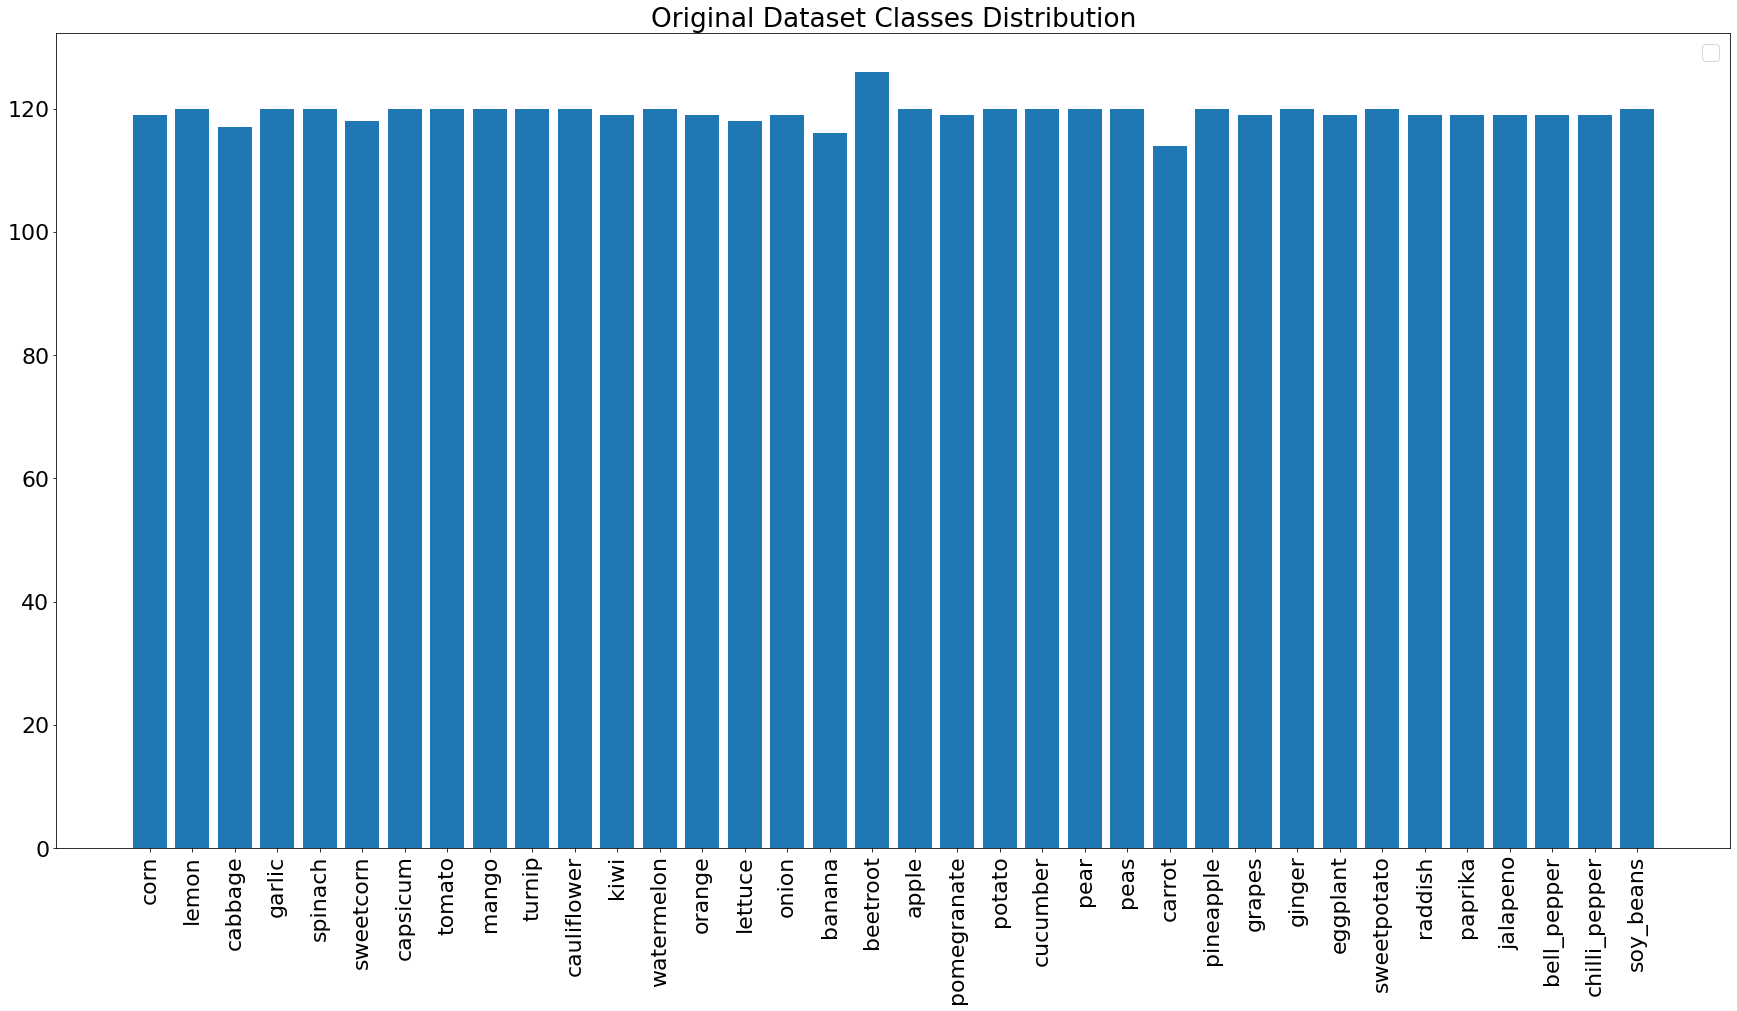

In [ ]:
classes_count = {}

# loop through all images
splits = os.listdir(PATH_ORIGINAL_DATASET)
for split in splits:
  class_labels = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split))
  for label in class_labels:
    files = os.listdir(os.path.join(PATH_ORIGINAL_DATASET, split, label))
    if label in classes_count:
      classes_count[label] = classes_count[label] + len(files)
    else:
      classes_count[label] = len(files)

print(classes_count)

plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 22})
plt.title('Original Dataset Classes Distribution')
plt.bar(classes_count.keys(), classes_count.values())
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

No handles with labels found to put in legend.


{'fruits': 1312, 'vegetables': 2985}


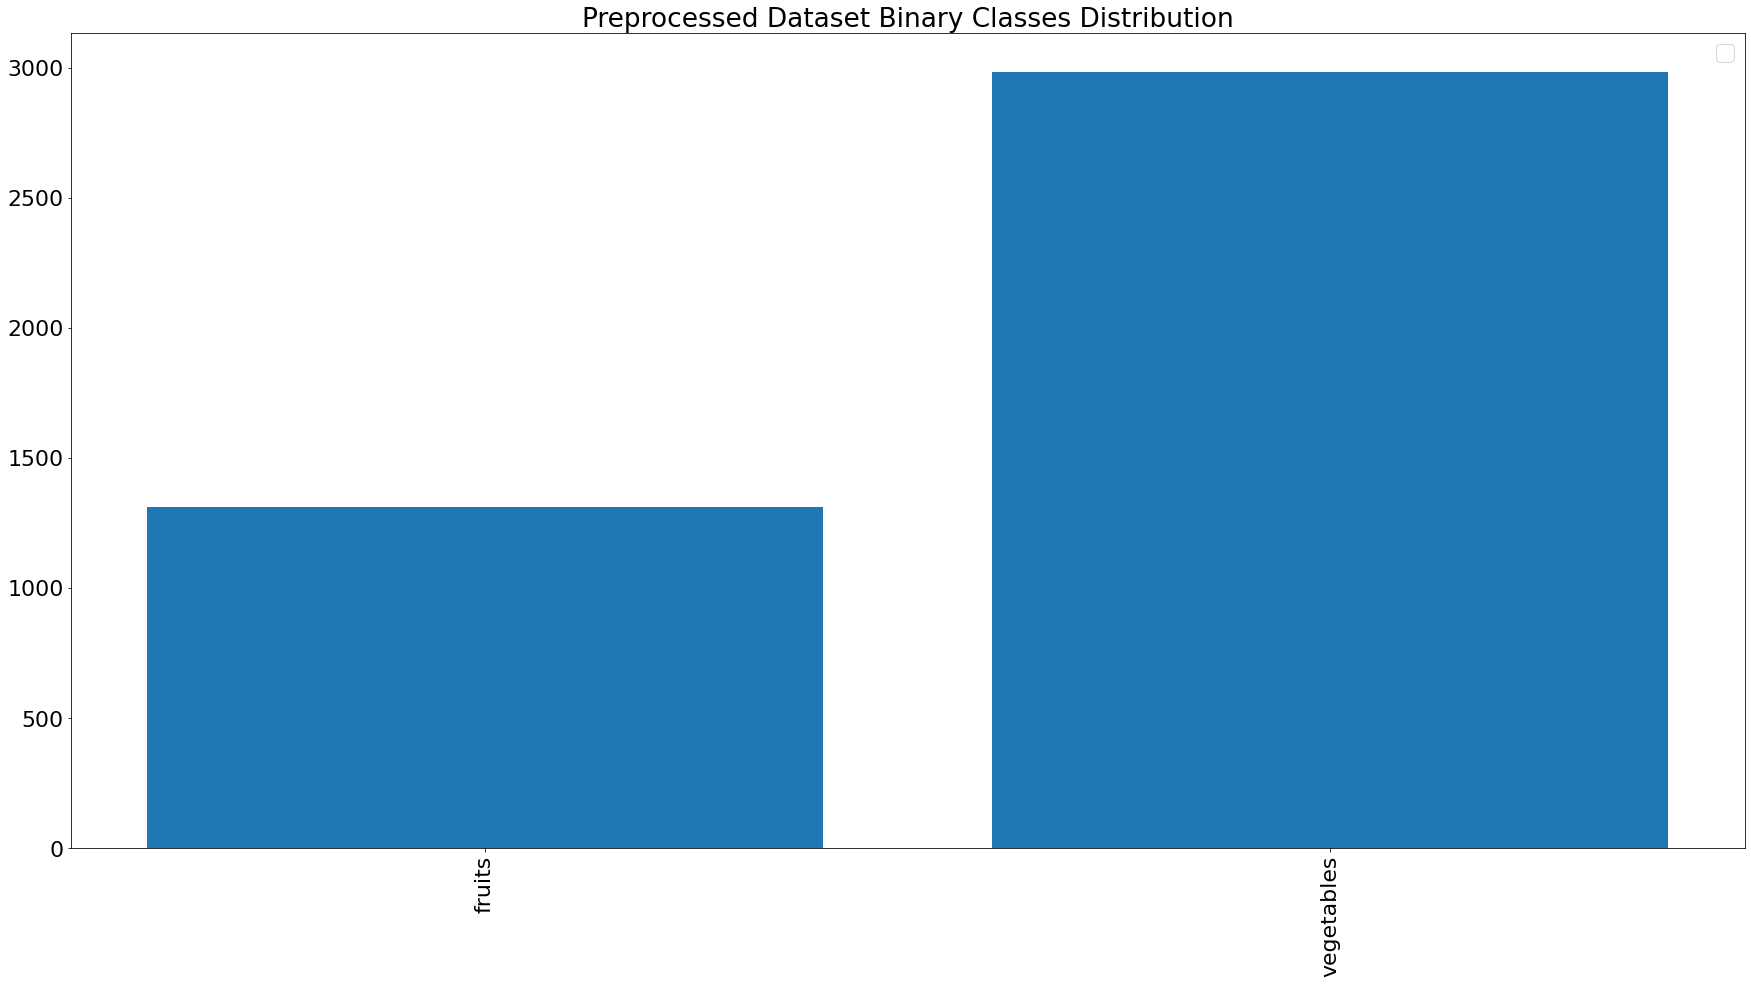

In [ ]:
classes_count = {}

# loop through all images
labels = os.listdir(PATH_ORIGINAL_BINARY_DATASET)
for label in labels:
  files = os.listdir(os.path.join(PATH_ORIGINAL_BINARY_DATASET, label))
  classes_count[label] = len(files)

print(classes_count)

plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 22})
plt.title('Preprocessed Dataset Binary Classes Distribution')
plt.bar(classes_count.keys(), classes_count.values())
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [ ]:
import random 

%matplotlib inline

def rotate(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

rcParams['figure.figsize'] = 11,8

# loop through all images
labels = os.listdir(PATH_PREPROCESSED_BINARY_DATASET)
for label in labels:
  if label == 'fruits':
    files = os.listdir(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label))
    for image_file in files:
      print(image_file)
      image = cv2.imread(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label, image_file))
      if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #rotated_image = rotate(image, random.randint(20, 340))
        #filename, file_extension = os.path.splitext(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label, image_file))
        #cv2.imwrite(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label, filename + '-rotated-' + str(i) + file_extension), rotated_image)
        fig, ax = plt.subplots(1, 1)
        ax.imshow(image)
        plt.show()
        plt.show(block=True)

In [ ]:
# loop through all images
labels = os.listdir(PATH_PREPROCESSED_BINARY_DATASET)
for label in labels:
  if label == 'fruits':
    files = os.listdir(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label))
    for image_file in files:
      if "rotated" in image_file:
        os.remove(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label, image_file))
      else:
        print(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label, image_file))

/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_11.png
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_12.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_14.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_13.png
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_10.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_15.png
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_16.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_17.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_18.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_19.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_359.jpg
/content/drive/Shareddrives/CIDL/dataset/preprocessed_binary/fruits/img_360.jpg
/content/drive/Shareddrives/CIDL/dataset/preproces

No handles with labels found to put in legend.


{'fruits': 1634, 'vegetables': 1835}


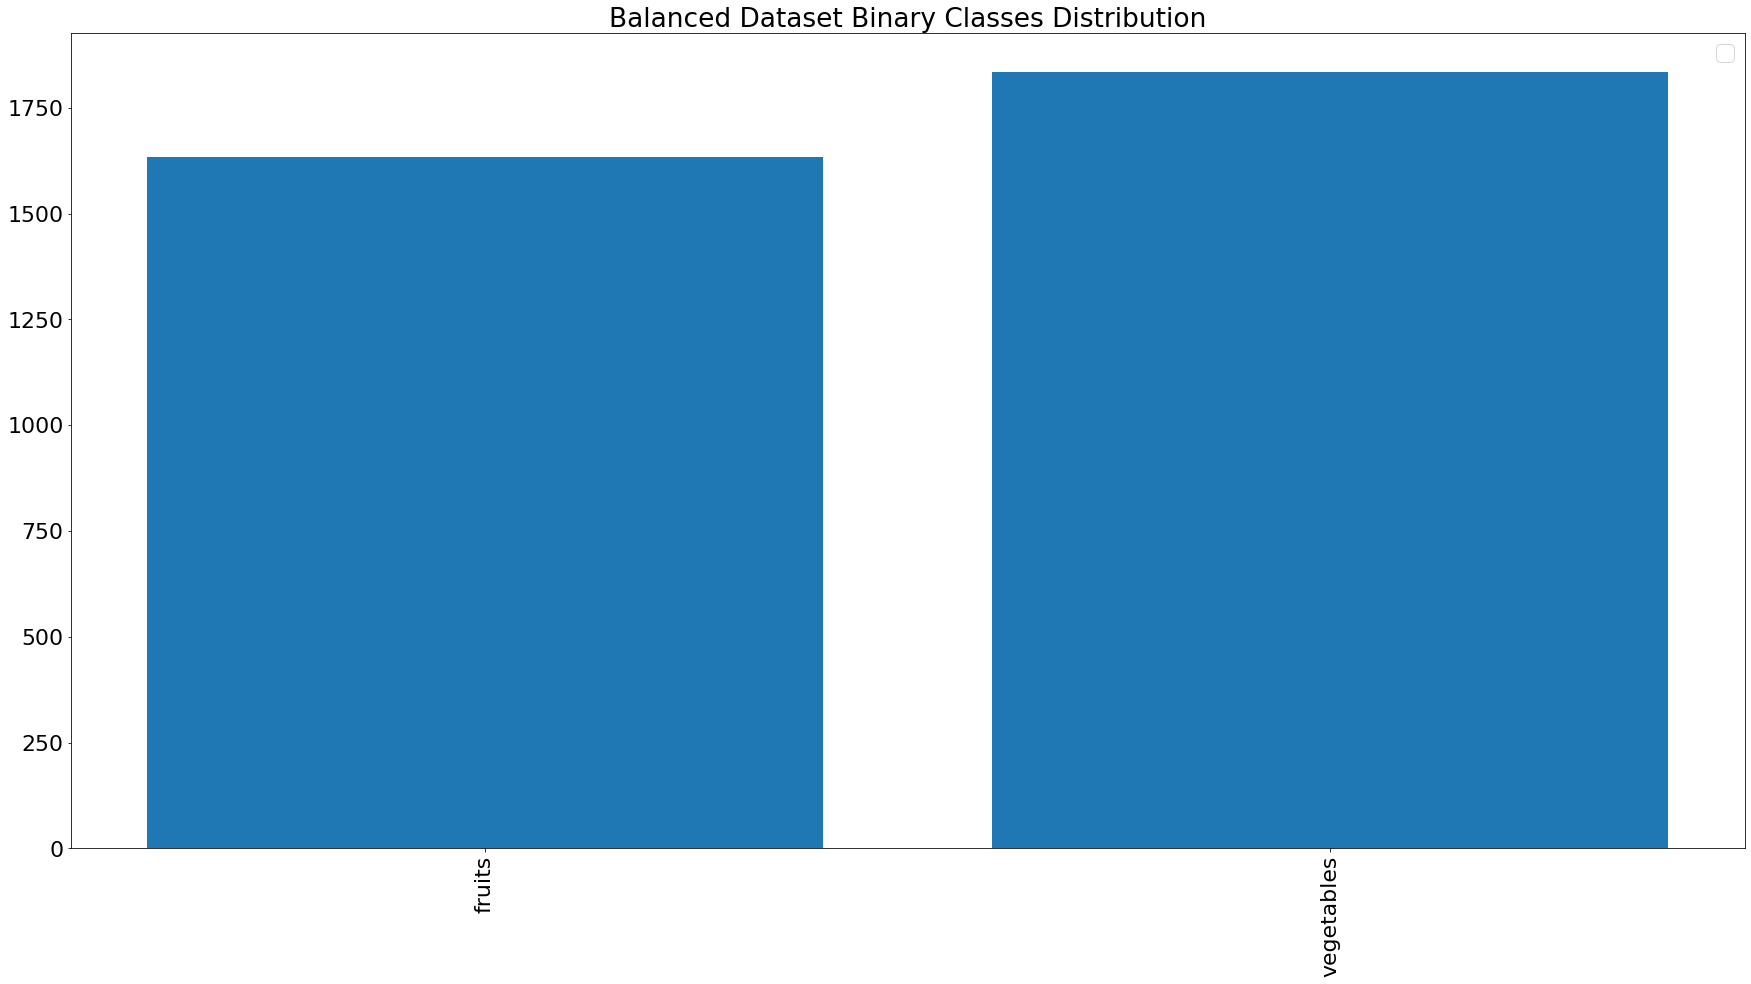

In [ ]:
classes_count = {}

# loop through all images
labels = os.listdir(PATH_PREPROCESSED_BINARY_DATASET)
for label in labels:
  files = os.listdir(os.path.join(PATH_PREPROCESSED_BINARY_DATASET, label))
  classes_count[label] = len(files)

print(classes_count)

plt.figure(figsize=(30,15))
plt.rcParams.update({'font.size': 22})
plt.title('Balanced Dataset Binary Classes Distribution')
plt.bar(classes_count.keys(), classes_count.values())
plt.xticks(rotation='vertical')
plt.legend()
plt.show()